In [0]:
import numpy as np
import h5py    
import random
import matplotlib as plt
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
import random
import time
import sys
import matplotlib.pyplot as plt
from tempfile import TemporaryFile

def formonehot(data,i):
    data = np.array(data)
    onehot = np.array(data/i)
    onehot[onehot != 1] = 0
    return onehot

def crossentropyloss(predicted,label):
    sum = 0
    for i in range(len(predicted)):
        labels = onehotlabel(label)
        sum += -1*np.sum(labels*np.log(np.amax(predicted[i])))
    return sum/372500

def onehotlabel(label):
    onehot = np.zeros(250)
    onehot[label] = 1
    return onehot

def softmax(predicteds):
    softmaxs = np.exp(predicteds - np.max(predicteds))/np.sum(np.exp(predicteds - np.max(predicteds)))
    return softmaxs
        
def calculatemse(error,o,flag =False):
    mse = 0
    err= 0
    error = error.T
    for errorofiteration in error:
        for column in errorofiteration:
            err+=column
        mse = mse + err*err
    mse = mse/np.array(o).shape[0]
    return mse

def classError(o,lbls):
    acc = accuracy(o,lbls)
    return acc

def accuracy(o,lbls):
    count = 0
    predict = np.argmax(o,axis=1)
    for i in range(lbls.shape[0]):
        if predict[i]==lbls[i]:
            count = count+ 1
    return count/lbls.shape[0]*100

def organizeInput(image):
    x = np.ones(32*32)
    index = 0
    for row in image:
        for column in row:
            x[index]=((column))
            index = index + 1
    return x

def activation(inn,deriv =False):
    inn = np.tanh(inn)
    if deriv == True:
        return 1-inn*inn
    return inn

# Rescale dataset columns to the range 0-1
def normalize_dataset(arr):
    arr = arr - np.amin(arr,axis=0)
    arr = arr / np.amax(arr,axis = 0)
    return arr

# Find the min and max values for each column
def organizeData(dataPath):
    data = h5py.File(dataPath,'r+')
    trainims =(data['trainims'])
    trainlbls =(data['trainlbls'])
    testims=(data['testims'])
    testlbls =(data['testlbls'])
    return trainims,trainlbls,testims,testlbls

def organizeData2(dataPath):
    data = h5py.File(dataPath,'r+')
    trainx =np.array((data['trainx']))
    traind =np.array((data['traind']))
    valx=(data['valx'])
    vald =(data['vald'])
    testx=(data['testx'])
    testd =(data['testd'])
    words = data['words']
    return trainx,traind,valx,vald,testx,testd,words
  
def addBiasToDataset(dataset):
    size = dataset.shape[0]
    biasInDataset = -1*np.ones(size)
    return np.hstack((dataset,(biasInDataset.reshape(-1,1))))

def addbiasToInputs(layerInput):
    return np.hstack((layerInput,[-1]))

def forwardpropagate(W1,W2,testdata):
    outputs = list()
    for img in testdata:
        output = activation(np.dot(W2,activation(addbiasToInputs(np.dot(W1,img)))))
        outputs.append(output)
    return np.array(outputs)

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def shuffle(data,lbls):
    deck = ((np.hstack((data,lbls.reshape(1,-1).T))))
    deck = np.array(sorted(deck, key=lambda k: random.random()))
    data = deck.T[:-1].T
    lbls = deck.T[-1]
    return data,lbls

def shuffle3(data,lbls):
    deck = ((np.hstack((data,lbls.reshape(1,-1).T))))
    deck = np.array(sorted(deck, key=lambda k: random.random()))
    data = deck.T[:-1].T
    lbls = deck.T[-1]
    return data,lbls

def formdata():
    Q2data =("/content/assign2_data1.h5")
    trainims,trainlbls,testims,testlbls = organizeData(Q2data)
    traindata = list()
    testdata = list()

    for image in trainims:
        inputs = organizeInput(image)
        traindata.append(inputs)

    for image in testims:
        inputs = organizeInput(image)
        testdata.append(inputs)

    traindata = np.array(traindata,dtype = float)
    trainlbls = np.array(trainlbls,dtype = float)
    testdata = np.array(testdata,dtype = float)
    testlbls = np.array(testlbls,dtype = float)

    traindata = (normalize_dataset(traindata))
    testdata = (normalize_dataset(testdata))
    traindata = addBiasToDataset(traindata)
    testdata = addBiasToDataset(testdata)
    return traindata,trainlbls,testdata,testlbls

In [0]:
def runNetwork(hiddenNo,epochno,miniBatchno,learningrate,alpha=0):
    print("Hidden layer number:"+str(hiddenNo)+" Learning rate:"+str(learningrate)+" Epoch number:"+str(epochno)+" Batch size:"+str(miniBatchno))
    # handling array constructions
    # trainx,traind,valx,vald,testx,testd = formdata2()
    traindata,trainlbls,testdata,testlbls = formdata()

    What= np.random.normal(0, 1/1025,(hiddenNo,1024))
    bhat = np.random.normal(0, 1/1025,(hiddenNo)).reshape(-1,1)
    What =np.hstack((What, bhat))

    W= np.random.normal(0, 1/hiddenNo,(2,hiddenNo))
    b = np.random.normal(0, 1/hiddenNo,(2)).reshape(1,-1)
    W =np.hstack((W, b.T))

    errorsFormse = list()
    errorsForClassification = list()
    errorsForTestClassifications = list()
    errorsForTestmse = list()
    # Start training process
    for epoch in range(epochno):
        errorsForEpochs = list()
        # display epoch index and current time
        if epoch==0:
            print("Training started.   Time: "+time.ctime())
        title = ("\r"+"Epoch no: "+str(epoch)+" in "+str(epochno))
        sys.stdout.write(title +" Time: " +time.ctime())
        sys.stdout.flush()
        time.sleep(1)
        trainouts = list()#--------------------------
        lblss = list()
        for iterateno in range(1900):
            # forward propagate
            # handling array constructions
            i = iterateno
            img = traindata[i]
            d = np.zeros(2)
            lbl = trainlbls[i]
            lblss.append(lbl)
            d[int(lbl)] = 1
            # activate hidden layer
            vhat = list(np.dot(What,img))
            vhat.append(-1)
            vhat = np.array(vhat,dtype = float)
            y = activation(vhat).T
            # activate output layer
            v = np.dot(W,y)
            o = activation(v)
            e = (d-o)/1900
            trainouts.append(o)#---------------------------
            # store the error
            errorsForEpochs.append(e)
            # back propagate
            # back propagate the output layer
            Tprime = activation(v,deriv = True)*np.identity(2,dtype=float)
            gradient = (np.dot(Tprime,e))
            # back propagate the hidden layer
            Tprimehat = activation(vhat,deriv = True)*np.identity(hiddenNo+1,dtype = float)
            gradienthat = (np.dot((np.dot(Tprimehat,W.T)),gradient))
            # mini batch updates
            if iterateno%miniBatchno== 0:
                if not(iterateno==0 and epoch==0):#The first iteration of the first epoch does not take any update
                    W +=learningrate*normalize(Wupdate)/miniBatchno
                    What+=learningrate*normalize(Whatupdate)/miniBatchno
                Wupdate = (np.dot(gradient.reshape(-1,1),y.reshape(1,-1)))
                Whatupdate = (np.dot(gradienthat.reshape(-1,1),img.reshape(-1,1).T)[:-1])
            else:
                Wupdate += (np.dot(gradient.reshape(-1,1),y.reshape(1,-1)))
                Whatupdate += (np.dot(gradienthat.reshape(-1,1),img.reshape(-1,1).T)[:-1])
        lblss = np.array(lblss)
        trainouts = np.array(trainouts)
        classificationError = classError(trainouts,lblss)
        errorsForClassification.append(classificationError)

        errorsForEpochs = np.array(errorsForEpochs)
        mse=calculatemse(errorsForEpochs,o).reshape(-1,1)
        errorsFormse.append(float(mse))

        WtT = W.T[:-1].T
        WthatT = (What.T[:-1]).T
        errorsForEpochsTest = list()
        testouts = list()
        for i in range(testdata.shape[0]):
            # forward propagate
            imgT = testdata[i][:-1]
            lblT = testlbls[i]
            # 
            dT = np.zeros(2)
            lblT = trainlbls[i]
            dT[int(lblT)] = 1

            vhatT =np.dot(WthatT,imgT).reshape(1,-1)
            yT = activation(vhatT).T

            vT = np.dot(WtT,yT)
            oT = activation(vT)

            eT = dT - oT
            testouts.append(oT)
            errorsForEpochsTest.append(eT)
        # lbls = np.array(lbls)
        testouts = np.array(testouts)
        testclassifications = classError(testouts,testlbls)
        errorsForTestClassifications.append(testclassifications)  

        errorsForEpochsTest = np.array(errorsForEpochsTest)
        msetest = calculatemse(errorsForEpochsTest,o).reshape(-1,1)
        errorsForTestmse.append(float(mse))
        if testclassifications>72:
            break
    # Adjusting weight matrices by de-concetanating the bias term
    print("Train mean squared errors for epochs")
    errorsFormse= np.array(errorsFormse)
    plt.plot(errorsFormse)
    plt.show()
    print("Train percentage classification errors for epochs")
    errorsForClassification = np.array(errorsForClassification)
    plt.plot(errorsForClassification)
    plt.show()
    print("Test mean squared errors for epochs")
    errorsForTestmse = np.array(errorsForTestmse)
    plt.plot(errorsForTestmse)
    plt.show()
    print("Test percentage classification errors for epochs")
    errorsForTestClassifications = np.array(errorsForTestClassifications)
    plt.plot(errorsForTestClassifications)
    plt.show()
    print("Maximum accuracy is obtained at epoch:"+str(np.argmax(errorsForTestClassifications))+" as "+str(np.amax(errorsForTestClassifications))+"%")

Hidden layer number:50 Learning rate:0.2 Epoch number:150 Batch size:10
Training started.   Time: Sun Nov 17 19:24:33 2019
Epoch no: 149 in 150 Time: Sun Nov 17 19:29:00 2019Train mean squared errors for epochs


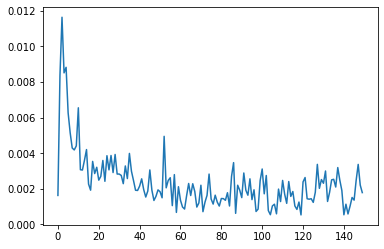

Train percentage classification errors for epochs


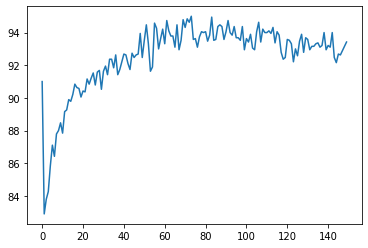

Test mean squared errors for epochs


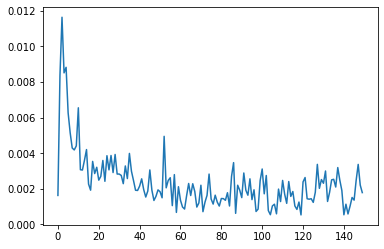

Test percentage classification errors for epochs


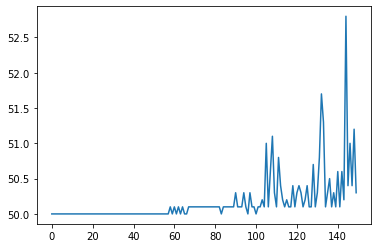

Maximum accuracy is obtained at epoch:144 as 52.800000000000004%
---------------------------------------------------------------
Hidden layer number:30 Learning rate:0.3 Epoch number:140 Batch size:30
Training started.   Time: Sun Nov 17 19:29:04 2019
Epoch no: 139 in 140 Time: Sun Nov 17 19:32:17 2019Train mean squared errors for epochs


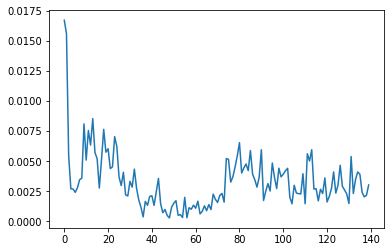

Train percentage classification errors for epochs


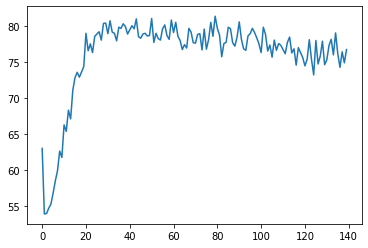

Test mean squared errors for epochs


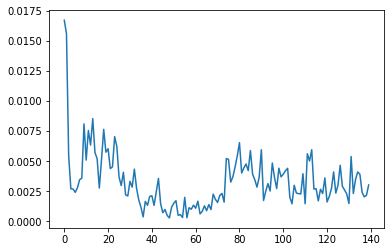

Test percentage classification errors for epochs


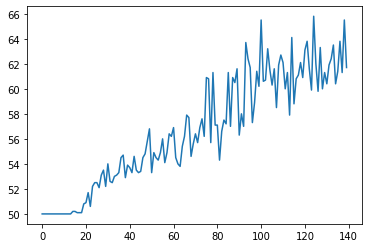

Maximum accuracy is obtained at epoch:124 as 65.8%
---------------------------------------------------------------
Hidden layer number:150 Learning rate:0.5 Epoch number:50 Batch size:40
Training started.   Time: Sun Nov 17 19:32:20 2019
Epoch no: 49 in 50 Time: Sun Nov 17 19:34:41 2019Train mean squared errors for epochs


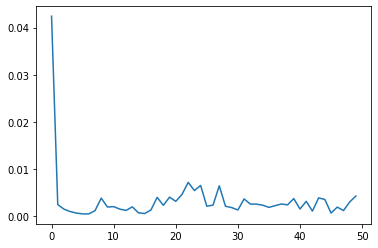

Train percentage classification errors for epochs


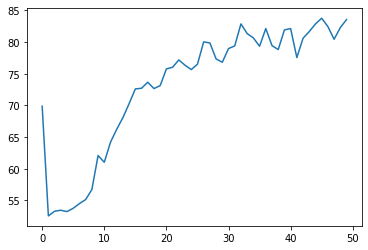

Test mean squared errors for epochs


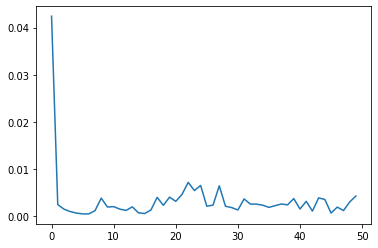

Test percentage classification errors for epochs


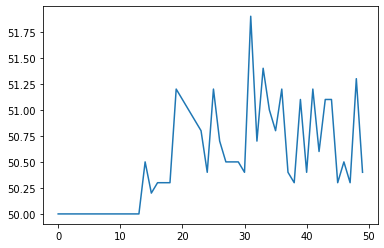

Maximum accuracy is obtained at epoch:31 as 51.9%


In [0]:
# hiddenNo,epochno,minibatchno,learningrate,alpha

runNetwork(30,100,30,0.3,0)
runNetwork(150,200,40,0.5,0)
runNetwork(30,300,60,0.3,0)

Hidden layer number:30 Learning rate:0.3 Epoch number:300 Batch size:60
Training started.   Time: Sun Nov 17 19:58:30 2019
Epoch no: 299 in 300 Time: Sun Nov 17 20:05:25 2019Train mean squared errors for epochs


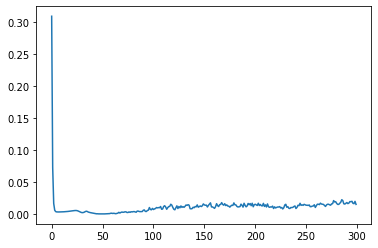

Train percentage classification errors for epochs


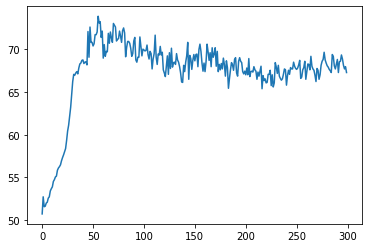

Test mean squared errors for epochs


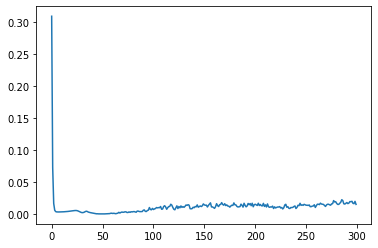

Test percentage classification errors for epochs


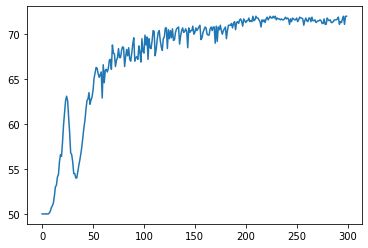

Maximum accuracy is obtained at epoch:207 as 72.0%


In [0]:
runNetwork(30,300,60,0.3,0)

In [0]:
def runNetwork2(hidden1No,hidden2No,epochno,miniBatchno,learningrate,alpha):
    print("Hidden1 layer number:"+str(hidden1No)+" Hidden2 layer number:"+str(hidden2No)+" Learning rate:"+str(learningrate)+" Epoch number:"+str(epochno)+" Batch size:"+str(miniBatchno))
    # handling array constructions
    traindata,trainlbls,testdata,testlbls = formdata()

    What1= np.random.normal(0, 1/1025,(hidden1No,1024))
    bhat1 = np.random.normal(0, 1/1025,(hidden1No)).reshape(-1,1)
    What1 =np.hstack((What1, bhat1))

    What2= np.random.normal(0, 1/hidden1No,(hidden2No,hidden1No))
    bhat2 = np.random.normal(0, 1/1/hidden1No,(hidden2No)).reshape(-1,1)
    What2 =np.hstack((What2, bhat2))

    W= np.random.normal(0, 1/hidden2No,(2,hidden2No))
    b = np.random.normal(0, 1/hidden2No,(2)).reshape(1,-1)
    W =np.hstack((W, b.T))

    errorsFormse = list()
    errorsForClassification = list()
    errorsForTestClassifications = list()
    errorsForTestmse = list()
    # Start training process
    for epoch in range(epochno):
        errorsForEpochs = list()
        # display epoch index and current time
        if epoch==0:
            print("Training started.   Time: "+time.ctime())
        title = ("\r"+"Epoch no: "+str(epoch)+" in "+str(epochno))
        sys.stdout.write(title +" Time: " +time.ctime())
        sys.stdout.flush()
        time.sleep(1)
        lbls = list()
        trainouts = list()#--------------------------
        for iterateno in range(1900):
            # forward propagate
            # handling array constructions
            i = random.randrange(traindata.shape[0])
            img = traindata[i]
            d = np.zeros(2)
            lbl = trainlbls[i]
            lbls.append(lbl)
            d[int(lbl)] = 1
            # activate hidden1 layer
            vhat1 = list(np.dot(What1,img))
            vhat1.append(-1)
            vhat1 = np.array(vhat1,dtype = float)
            y1 = activation(vhat1).T
            # activate hidden2 layer
            vhat2 = list(np.dot(What2,y1))
            vhat2.append(-1)
            vhat2 = np.array(vhat2,dtype = float)
            y2 = activation(vhat2).T
            # activate output layer
            v = np.dot(W,y2)
            o = activation(v)
            trainouts.append(o)#---------------------------
            e = (d-o)/1900
            errorsForEpochs.append(e)
            # back propagate
            # back propagate the output layer
            Tprime = activation(v,deriv = True)*np.identity(2,dtype=float)
            gradient = (np.dot(Tprime,e))
            # back propagate the hidden2 layer
            Tprimehat2 = activation(vhat2,deriv = True)*np.identity(hidden2No+1,dtype = float)
            gradienthat2 = (np.dot((np.dot(Tprimehat2,W.T)),gradient))
            # back propagate the hidden1 layer
            Tprimehat1 = activation(vhat1,deriv = True)*np.identity(hidden1No+1,dtype = float)
            gradienthat1 = (np.dot((np.dot(Tprimehat1,What2.T)),gradienthat2[:-1]))
            # mini batch updates

            if iterateno%miniBatchno== 0:
                Wupdate = (np.dot(gradient.reshape(-1,1),y2.reshape(1,-1)))
                What2update = (np.dot(gradienthat2.reshape(-1,1),y1.reshape(-1,1).T)[:-1])
                What1update = (np.dot(gradienthat1.reshape(-1,1),img.reshape(-1,1).T)[:-1])

                if not(iterateno==0 and epoch==0):#The first iteration of the first epoch does not take any update
                # batch updates
                    Wold = W
                    W +=normalize(learningrate*(Wupdate))/miniBatchno
                    W = normalize(W)
                    W +=alpha*((W-Wold))
                    W = normalize(W)
                    
                    What2old = What2
                    What2+=normalize(learningrate*(What2update))/miniBatchno
                    What2 = normalize(What2)                    
                    What2+=alpha*((What2-What2old))
                    What2 = normalize(What2)

                    What1old = What1
                    What1+= normalize(learningrate*(What1update))/miniBatchno
                    What1 = normalize(What1)
                    What1+= alpha*((What1-What1old))
                    What1 = normalize(What1)
            else:
                Wupdate += (np.dot(gradient.reshape(-1,1),y2.reshape(1,-1)))
                What2update += (np.dot(gradienthat2.reshape(-1,1),y1.reshape(1,-1))[:-1])
                What1update += (np.dot(gradienthat1.reshape(-1,1),img.reshape(-1,1).T)[:-1])
        lbls = np.array(lbls)
        trainouts = np.array(trainouts)
        classificationError = classError(trainouts,lbls)
        errorsForClassification.append(classificationError)

        errorsForEpochs = np.array(errorsForEpochs)
        mse=calculatemse(errorsForEpochs,o).reshape(-1,1)
        errorsFormse.append(float(mse))   

        WtT = W.T[:-1].T
        Wthat2T = (What2.T[:-1]).T
        Wthat1T = (What1.T[:-1]).T
        errorsForEpochsTest = list()
        testouts = list()
        for i in range(testdata.shape[0]):
            # forward propagate
            imgT = testdata[i][:-1]
            lblT = testlbls[i]
            # 
            dT = np.zeros(2)
            lblT = trainlbls[i]
            dT[int(lblT)] = 1

            vhat1T =np.dot(Wthat1T,imgT).reshape(1,-1)
            y1T = activation(vhat1T).T

            vhat2T =np.dot(Wthat2T,y1T).reshape(1,-1)
            y2T = activation(vhat2T).T

            vT = np.dot(WtT,y2T)
            oT = activation(vT)

            eT = (dT-oT)/1900

            testouts.append(oT)
            errorsForEpochsTest.append(eT)
        testouts = np.array(testouts)
        testclassifications = classError(testouts,testlbls)
        errorsForTestClassifications.append(testclassifications)  
        # print(" Test classificaiton error: "+str(testclassifications))
        if testclassifications>75:
            break
        errorsForEpochsTest = np.array(errorsForEpochsTest)
        msetest = calculatemse(errorsForEpochsTest,o).reshape(-1,1)
        errorsForTestmse.append(float(mse))        
    # Adjusting weight matrices by de-concetanating the bias term

    print("Train mean squared errors for epochs")
    errorsFormse= np.array(errorsFormse)
    plt.plot(errorsFormse)
    plt.show()
    print("Train percentage classification errors for epochs")
    errorsForClassification = np.array(errorsForClassification)
    plt.plot(errorsForClassification)
    plt.show()
    print("Test mean squared errors for epochs")
    errorsForTestmse = np.array(errorsForTestmse)
    plt.plot(errorsForTestmse)
    plt.show()
    print("Test percentage classification errors for epochs")
    errorsForTestClassifications = np.array(errorsForTestClassifications)
    plt.plot(errorsForTestClassifications)
    plt.show()
    print("Maximum accuracy is obtained at epoch:"+str(np.argmax(errorsForTestClassifications))+" as "+str(np.amax(errorsForTestClassifications))+"%")

Hidden1 layer number:300 Hidden2 layer number:100 Learning rate:0.2 Epoch number:600 Batch size:40
Training started.   Time: Sun Nov 17 18:58:31 2019
Epoch no: 24 in 600 Time: Sun Nov 17 19:01:06 2019Train mean squared errors for epochs


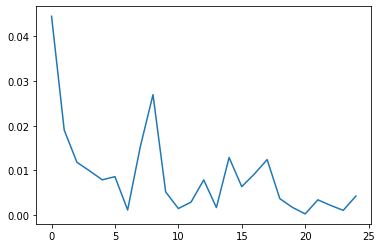

Train percentage classification errors for epochs


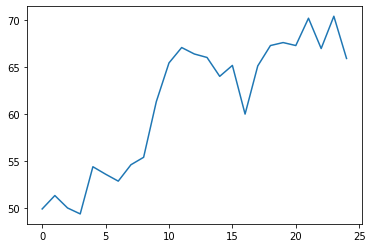

Test mean squared errors for epochs


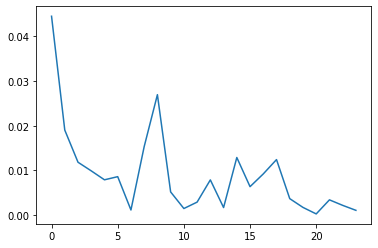

Test percentage classification errors for epochs


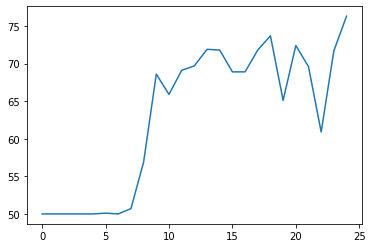

Maximum accuracy is obtained at epoch:24 as 76.3%
Hidden1 layer number:100 Hidden2 layer number:75 Learning rate:0.15 Epoch number:100 Batch size:60
Training started.   Time: Sun Nov 17 19:01:14 2019
Epoch no: 52 in 100 Time: Sun Nov 17 19:03:36 2019Train mean squared errors for epochs


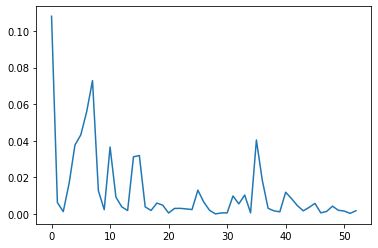

Train percentage classification errors for epochs


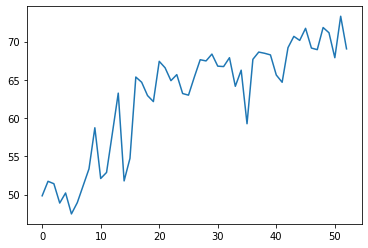

Test mean squared errors for epochs


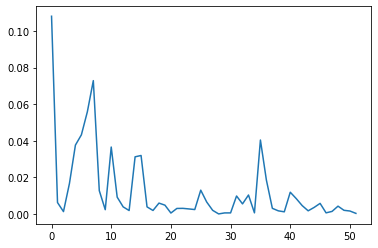

Test percentage classification errors for epochs


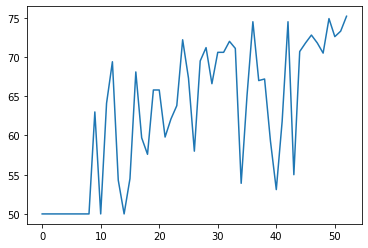

Maximum accuracy is obtained at epoch:52 as 75.2%
Hidden1 layer number:150 Hidden2 layer number:50 Learning rate:0.13 Epoch number:300 Batch size:100
Training started.   Time: Sun Nov 17 19:03:41 2019
Epoch no: 138 in 300 Time: Sun Nov 17 19:11:14 2019Train mean squared errors for epochs


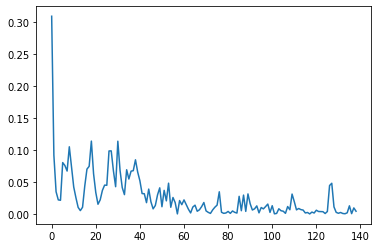

Train percentage classification errors for epochs


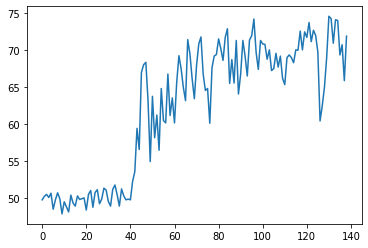

Test mean squared errors for epochs


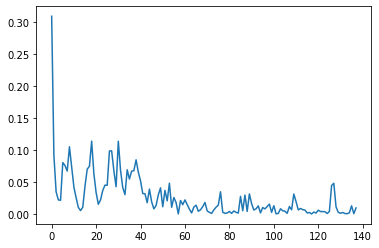

Test percentage classification errors for epochs


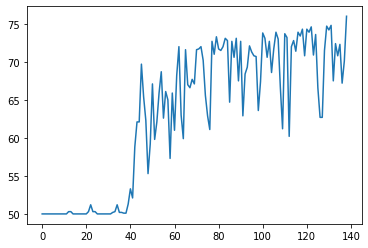

Maximum accuracy is obtained at epoch:138 as 76.0%


In [0]:
# hiddenNo1,hiddenNo2,epochno,minibatchno,learningrate
runNetwork2(300,100,600,40,0.2,0)

runNetwork2(100,75,100,60,0.15,0.1)

runNetwork2(150,50,300,100,0.13,0.15)

In [0]:
def formdata2():
    Q2data2 = ("/content/assign2_data2.h5")
    trainx,traind,valx,vald,testx,testd,words = organizeData2(Q2data2)
    trainx = np.array(trainx)
    trainx,traind = shuffle3(trainx,traind)
    print("Data for train")
    onehot = []
    for k in range(250):
        i = k+1
        index = i+1
        onehot = formonehot(trainx,i)
        if i == 1:
            onehots = onehot
        else:
            onehots = np.concatenate((onehots, onehot),axis =1)
        title = ("\r"+"Handling dataset, creating embedding matrix:   "+str(i/250*100)+"%")
        sys.stdout.write(title +" Time: " +time.ctime())
        sys.stdout.flush()
        time.sleep(1)

    print("\nData for validation")
    onehotv = []
    for k in range(250):
        i = k+1
        index = i+1
        onehotv = formonehot(valx,i)
        if i == 1:
            onehotsv = onehotv
        else:
            onehotsv = np.concatenate((onehotsv, onehotv),axis =1)
        title = ("\r"+"Handling dataset, creating embedding matrix:   "+str(i/250*100)+"%")
        sys.stdout.write(title +" Time: " +time.ctime())
        sys.stdout.flush()
        time.sleep(1)

    print("\nData for test")
    onehott =[]
    for k in range(250):
        i = k+1
        indext= i+1
        onehott = formonehot(testx,i)
        
        if i == 1:
            onehotst = onehott
        else:
            onehotst = np.concatenate((onehotst, onehott),axis =1)
        title = ("\r"+"Handling dataset, creating embedding matrix:   "+str(i/250*100)+"%")
        sys.stdout.write(title +" Time: " +time.ctime())
        sys.stdout.flush()
        time.sleep(1)  

    onehots = onehots.T
    onehotsv = onehotsv.T
    onehotst = onehotst.T


    return onehots,onehotsv,onehotst,traind,vald,testd,words
def formdata3():
    print("Constructing onehots")
    onehots,onehotsv,onehotst,traind,vald,testd,words = formdata2()
    firstWord = list()
    secondWord=list()
    thirdWord = list()
    print("Constructing word arrays")
    print("Train data")
    for i in range(int(len(onehots)/3)):
        firstWordIndex = 3*i
        secondWordIndex = 3*i+1
        thirdWordIndex = 3*i+2

        firstWord.append(onehots[firstWordIndex])
        secondWord.append(onehots[secondWordIndex])
        thirdWord.append(onehots[thirdWordIndex])
    firstWord = np.array(firstWord).T
    secondWord = np.array(secondWord).T
    thirdWord = np.array(thirdWord).T
    print("Validation data")
    firstWordv = list()
    secondWordv=list()
    thirdWordv = list()
    for i in range(int(len(onehotsv)/3)):
        firstWordIndex = 3*i
        secondWordIndex = 3*i+1
        thirdWordIndex = 3*i+2

        firstWordv.append(onehotsv[firstWordIndex])
        secondWordv.append(onehotsv[secondWordIndex])
        thirdWordv.append(onehotsv[thirdWordIndex])
    firstWordv = np.array(firstWordv).T
    secondWordv = np.array(secondWordv).T
    thirdWordv = np.array(thirdWordv).T
    print("Test data")
    firstWordt = list()
    secondWordt=list()
    thirdWordt = list()
    for i in range(int(len(onehotst)/3)):
        firstWordIndex = 3*i
        secondWordIndex = 3*i+1
        thirdWordIndex = 3*i+2

        firstWordt.append(onehotst[firstWordIndex])
        secondWordt.append(onehotst[secondWordIndex])
        thirdWordt.append(onehotst[thirdWordIndex])
    firstWordt = np.array(firstWordt).T
    secondWordt = np.array(secondWordt).T
    thirdWordt = np.array(thirdWordt).T
    return firstWord,secondWord,thirdWord,firstWordv,secondWordv,thirdWordv,firstWordt,secondWordt,thirdWordt,traind,vald,testd,words

    # firstWord,secondWord,thirdWord,firstWordv,secondWordv,thirdWordv,firstWordt,secondWordt,thirdWordt,traind,vald,testd

In [0]:
firstWord,secondWord,thirdWord,firstWordv,secondWordv,thirdWordv,firstWordt,secondWordt,thirdWordt,traind,vald,testd,words = formdata3()

Constructing onehots
Data for train
Handling dataset, creating embedding matrix:   100.0% Time: Sun Nov 17 14:42:16 2019
Data for validation
Handling dataset, creating embedding matrix:   100.0% Time: Sun Nov 17 14:46:42 2019
Data for test
Handling dataset, creating embedding matrix:   100.0% Time: Sun Nov 17 14:51:08 2019Constructing word arrays
Train data
Validation data
Test data


In [0]:
print(words[26])

# print(firstWord.shape)
# print(firstWordv.shape)
# print(firstWordt.shape)

# print(firstWord[0])
# print(firstWordt[0])

b'only'


In [0]:
# ff = list()
# ss = list()
# tt = list()
# dd = list()
# oo = list()
def runNetwork3(D,hidden2No,epochno,miniBatchno,learningrate,alpha):
    print("Hidden1 layer number:"+str(D)+" Hidden2 layer number:"+str(hidden2No)+" Learning rate:"+str(learningrate)+" Epoch number:"+str(epochno)+" Batch size:"+str(miniBatchno))
    # handling array constructions


    What1= np.random.normal(0, 1/10,(int(D),250))

    hidden1No = D
    What2= np.random.normal(0, 1/hidden1No,(hidden2No,3*D))
    bhat2 = np.random.normal(0, 1/1/hidden1No,(hidden2No)).reshape(-1,1)
    What2 =np.hstack((What2, bhat2))

    W= np.random.normal(0, 1/hidden2No,(250,hidden2No))
    b = np.random.normal(0, 1/hidden2No,(250)).reshape(1,-1)
    W =np.hstack((W, b.T))


    errorsFormse = list()
    errorsForClassification = list()
    errorsForTestClassifications = list()
    errorsForTestmse = list()
    errorsForTestClassificationst = list()
    errorsForTestmset = list()


    # Start training process
    for epoch in range(epochno):
        errorsForEpochs = list()
        # display epoch index and current time
        if epoch==0:
            print("Training started.   Time: "+time.ctime())
        title = ("\r\r"+"Epoch no: "+str(epoch)+" in "+str(epochno))
        sys.stdout.write(title +" Time: " +time.ctime())
        sys.stdout.flush()
        time.sleep(1)
        trainouts = list()#--------------------------
        lbls = list()
        lblst = list()
        for iterateno in range(372500):
            # forward propagate
            # handling array constructions
            i = iterateno

            firstw = firstWord[i]
            secondw = secondWord[i]
            thirdw = thirdWord[i]

            first = (np.dot(What1,firstw))
            second = (np.dot(What1,secondw))
            third = (np.dot(What1,thirdw))
            

            d = np.zeros(250)
            lbl = traind[i]-1
            lbls.append(lbl)
            d[int(lbl)] = 1
            # activate hidden layer
            vhat1 = np.append(np.concatenate((first,second,third)),([[-1]]))
            vhat1 = np.array(vhat1)

            y1 = activation(vhat1).T
            # activate hidden2 layer
            vhat2 = np.append(np.dot(What2,y1),([[-1]]))
            y2 = activation(vhat2).T
            # activate output layer
            v = np.dot(W,y2)
            o = softmax(v)
            # trainouts.append(o)#---------------------------
            e = (d-o)
            # errorsForEpochs.append(np.amax(o)+1)
            # /////////////////////////////////////////////////
            Tprime = e*np.identity(250,dtype=float)
            gradient = (np.dot(Tprime,e))
            # back propagate the hidden2 layer
            Tprimehat2 = activation(vhat2,deriv = True)*np.identity(hidden2No+1,dtype = float)
            gradienthat2 = (np.dot((np.dot(Tprimehat2,W.T)),gradient))
            # back propagate the hidden1 layer
            Tprimehat1first = np.identity(hidden1No,dtype = float)
            gradienthat1first = (np.dot((np.dot(Tprimehat1first,(What2.T[:D]))),gradienthat2[:-1]))
            Tprimehat1second = np.identity(hidden1No,dtype = float)
            gradienthat1second = (np.dot((np.dot(Tprimehat1second,What2.T[D:2*D])),gradienthat2[:-1]))
            Tprimehat1third = np.identity(hidden1No,dtype = float)
            gradienthat1third = (np.dot((np.dot(Tprimehat1third,What2.T[2*D:3*D])),gradienthat2[:-1]))
            # mini batch updates
            # print(np.argmax(o))

            if iterateno%miniBatchno== 0:
                if not(iterateno==0 and epoch==0):#The first iteration of the first epoch does not take any update
                # batch updates
                    Wold = W
                    W +=learningrate*(Wupdate)/miniBatchno
                    # W = normalize(W)
                    W +=alpha*((W-Wold))
                    # W = normalize(W)
                    
                    What2old = What2
                    What2+=learningrate*(What2update[:-1])/miniBatchno
                    # What2 = normalize(What2)                    
                    What2+=alpha*((What2-What2old))
                    # What2 = normalize(What2)

                    What1old = What1
                    What1+= (learningrate*(What1update))/miniBatchno
                    # What1 = normalize(What1)
                    What1+= alpha*((What1-What1old))
                    # What1 = normalize(What1)
                Wupdate = normalize(np.dot(gradient.reshape(-1,1),y2.reshape(1,-1)))
                What2update = normalize(np.dot(gradienthat2.reshape(-1,1),y1.reshape(1,-1)))
                What1updatefirst = (np.dot(gradienthat1first.reshape(-1,1),firstw.reshape(-1,1).T))
                What1updatesecond = (np.dot(gradienthat1second.reshape(-1,1),secondw.reshape(-1,1).T))
                What1updatethird = (np.dot(gradienthat1third.reshape(-1,1),thirdw.reshape(-1,1).T))
                # print(gradienthat1first.reshape(-1,1).shape)
                # print(third.reshape(-1,1).T.shape)
                What1update = normalize(What1updatethird+What1updatesecond+What1updatethird)
            else:
                Wupdate += normalize(np.dot(gradient.reshape(-1,1),y2.reshape(1,-1)))
                What2update += normalize(np.dot(gradienthat2.reshape(-1,1),y1.reshape(1,-1)))
                What1updatefirst = (np.dot(gradienthat1first.reshape(-1,1),firstw.reshape(-1,1).T))
                What1updatesecond = (np.dot(gradienthat1second.reshape(-1,1),secondw.reshape(-1,1).T))
                What1updatethird = (np.dot(gradienthat1third.reshape(-1,1),thirdw.reshape(-1,1).T))
                What1update += normalize(What1updatethird+What1updatesecond+What1updatethird)

        # lbls = np.array(lbls)
        # trainouts = np.array(trainouts)
        # classificationError = classError(trainouts,lbls)
        # errorsForClassification.append(classificationError)

        # errorsForEpochs = np.array(errorsForEpochs)
        # mse=crossentropyloss(errorsForEpochs,lbls).reshape(-1,1)
        # errorsFormse.append(float(mse))   

        WtT = W.T[:-1].T
        What2T = (What2.T[:-1]).T
        What1T = (What1.T[:-1]).T
        errorsForEpochsTest = list()
        testouts = list()
        lbls = list()

        for i in range(vald.shape[0]):
            # forward propagate
            firstw = firstWordv[i][:-1]
            secondw = secondWordv[i][:-1]
            thirdw = thirdWordv[i][:-1]

            first = (np.dot(What1T,firstw))
            second = (np.dot(What1T,secondw))
            third = (np.dot(What1T,thirdw))

            d = np.zeros(250)
            lbl = vald[i]-1
            lbls.append(lbl)
            d[int(lbl)] = 1
            # activate hidden layer
            vhat1 = np.concatenate((first,second,third))
            vhat1 = np.array(vhat1)

            y1 = activation(vhat1).T
            # activate hidden2 layer
            vhat2 = (np.dot(What2T,y1))
            y2 = activation(vhat2).T
            # activate output layer
            v = np.dot(WtT,y2)
            o = softmax(v)
            testouts.append(o)#---------------------------
            e = (d-o)
            errorsForEpochsTest.append(np.amax(o))

            # if i==10 or i==110 or i ==1110:
            #     ff.append(firstw)
            #     ss.append(secondw)
            #     tt.append(thirdw)
            #     dd.append(words[lbl])
            #     oo.append(o)
        lbls = np.array(lbls)
        testouts = np.array(testouts)
        testclassifications = classError(testouts,lbls)
        errorsForTestClassifications.append(testclassifications)  
        # print(" Test classificaiton error: "+str(testclassifications))

        errorsForEpochsTest = np.array(errorsForEpochsTest)
        msetest = crossentropyloss(errorsForEpochsTest,lbls).reshape(-1,1)
        errorsForTestmse.append(float(msetest))        
        print("----------------")
        print(testclassifications)
        print(msetest)
        print("----------------")
        
        errorsForEpochsTestt = list()
        testoutst = list()
        lblst = list()
        for i in range(testd.shape[0]):
            # forward propagate
            firstw = firstWordt[i]
            secondw = secondWordt[i]
            thirdw = thirdWordt[i]

            first = (np.dot(What1,firstw))
            second = (np.dot(What1,secondw))
            third = (np.dot(What1,thirdw))
            

            d = np.zeros(250)
            lbl = testd[i]-1
            lblst.append(lbl)
            d[int(lbl)] = 1
            # activate hidden layer
            vhat1 = np.append(np.concatenate((first,second,third)),([[-1]]))
            vhat1 = np.array(vhat1)

            y1 = activation(vhat1).T
            # activate hidden2 layer
            vhat2 = list(np.dot(What2,y1))
            vhat2.append(-1)
            vhat2 = np.array(vhat2,dtype = float)
            y2 = activation(vhat2).T
            # activate output layer
            v = np.dot(W,y2)
            o = softmax(v)
            testoutst.append(o)#---------------------------
            e = (d-o)
            errorsForEpochsTestt.append(np.amax(o))
        lblst = np.array(lblst)
        testoutst = np.array(testoutst)
        testclassificationst= classError(testoutst,lbls)
        errorsForTestClassificationst.append(testclassificationst)  
        # print(" Test classificaiton error: "+str(testclassifications))

        errorsForEpochsTestt = np.array(errorsForEpochsTestt)
        msetestt = crossentropyloss(errorsForEpochsTestt,lbls).reshape(-1,1)
        errorsForTestmse.append(float(msetest))        
        print("----------------")
        print(testclassificationst)
        print(msetestt)
        print("----------------")
              
    # Adjusting weight matrices by de-concetanating the bias term
    print("Train mean squared errors for epochs")
    errorsFormse= np.array(errorsFormse)
    plt.plot(errorsFormse)
    plt.show()
    print("Train percentage classification errors for epochs")
    errorsForClassification = np.array(errorsForClassification)
    plt.plot(errorsForClassification)
    plt.show()
    print("Test mean squared errors for epochs")
    errorsForTestmse = np.array(errorsForTestmse)
    plt.plot(errorsForTestmse)
    plt.show()
    print("Test percentage classification errors for epochs")
    errorsForTestClassifications = np.array(errorsForTestClassifications)
    plt.plot(errorsForTestClassifications)
    plt.show()
    print("Maximum accuracy is obtained at epoch:"+str(np.argmax(errorsForTestClassifications))+" as "+str(np.amax(errorsForTestClassifications))+"%")

In [0]:
runNetwork3(32,256,7,2,0.15,0.85)

Hidden1 layer number:32 Hidden2 layer number:256 Learning rate:0.15 Epoch number:7 Batch size:2
Training started.   Time: Sun Nov 17 19:13:16 2019
Epoch no: 0 in 7 Time: Sun Nov 17 19:13:16 2019----------------
17.369892473118277
[[0.0242349]]
----------------
----------------
17.369892473118277
[[0.]]
----------------
Epoch no: 1 in 7 Time: Sun Nov 17 19:14:19 2019----------------
17.378494623655914
[[0.00639828]]
----------------
----------------
17.378494623655914
[[0.]]
----------------
Epoch no: 2 in 7 Time: Sun Nov 17 19:15:21 2019

KeyboardInterrupt: ignored